# Difference in (weighted) mean - historical and observational (MÉRA)

- Weighted means take into account the number of days in each month

In [1]:
# import libraries
import glob
import importlib
import itertools
import os
import sys
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import climag.plot_configs as cplt
import climag.plot_stats as cstats
import rasterio as rio

In [2]:
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["EURO-CORDEX", "HiResIreland"]

In [3]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    data = data.drop_vars(
        [
            "bm_gv",
            "bm_gr",
            "bm_dv",
            "bm_dr",
            "age_gv",
            "age_gr",
            "age_dv",
            "age_dr",
            "omd_gv",
            "omd_gr",
            "lai",
            "env",
            "wr",
            "aet",
            "sen_gv",
            "sen_gr",
            "abs_dv",
            "abs_dr",
            "c_bm",
            "bm",
            "pgro",
            "i_bm",
            "h_bm",
        ]
    )

    return data

In [4]:
def combine_datasets(dataset_dict, dataset_crs):
    dataset = xr.combine_by_coords(
        dataset_dict.values(), combine_attrs="override"
    )
    dataset.rio.write_crs(dataset_crs, inplace=True)

    return dataset

In [5]:
def generate_stats(dataset):
    ds = {}

    for model in model_list:
        # auto-rechunking may cause NotImplementedError with object dtype
        # where it will not be able to estimate the size in bytes of object
        # data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds[model] = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data",
                    "ModVege",
                    dataset,
                    "historical",
                    model,
                    f"*{dataset}*{model}*historical*.nc",
                )
            ),
            chunks=CHUNKS,
            decode_coords="all",
        )

        # copy CRS
        crs_ds = ds[model].rio.crs

        # remove spin-up year
        ds[model] = ds[model].sel(time=slice("1981", "2005"))

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds[model] = ds[model].convert_calendar("360_day", align_on="year")

        # assign new coordinates and dimensions
        ds[model] = ds[model].assign_coords(model=model)
        ds[model] = ds[model].expand_dims(dim="model")

        # drop unnecessary variables
        ds[model] = keep_minimal_vars(data=ds[model])

        # weighted mean
        weights = (
            ds[model]["time"].dt.days_in_month.groupby("time.year")
            / ds[model]["time"].dt.days_in_month.groupby("time.year").sum()
        )

        # test that the sum of weights for each season is one
        np.testing.assert_allclose(
            weights.groupby("time.year").sum().values,
            np.ones(len(set(weights["year"].values))),
        )

        # calculate the weighted average
        ds[model] = (ds[model] * weights).groupby("time.year").sum(dim="time")

    # combine data
    ds = combine_datasets(ds, crs_ds)

    # overall mean
    ds = ds.mean(dim="year", skipna=True)

    # ensemble mean
    ds_ens = (
        ds.mean(dim="model", skipna=True)
        .assign_coords(model="Ensemble")
        .expand_dims(dim="model")
    )

    # combine
    ds = xr.merge([ds, ds_ens])

    # sort models
    model_list_ = model_list.copy()
    model_list_.append("Ensemble")
    ds = ds.reindex(model=model_list_)

    # MERA
    mera = xr.open_mfdataset(
        glob.glob(
            os.path.join("data", "ModVege", "MERA", "*MERA_FC3hr_3_day*.nc")
        ),
        chunks="auto",
        decode_coords="all",
    )

    # remove spin-up year
    mera = mera.sel(time=slice("1981", "2005"))

    # drop unnecessary variables
    mera = keep_minimal_vars(data=mera)

    # weighted mean
    weights = (
        mera["time"].dt.days_in_month.groupby("time.year")
        / mera["time"].dt.days_in_month.groupby("time.year").sum()
    )

    # test that the sum of weights for each season is one
    np.testing.assert_allclose(
        weights.groupby("time.year").sum().values,
        np.ones(len(set(weights["year"].values))),
    )

    # calculate the weighted average
    mera = (mera * weights).groupby("time.year").sum(dim="time")

    # overall mean
    mera = mera.mean(dim="year", skipna=True)

    # reassign projection
    mera.rio.write_crs(cplt.lambert_conformal, inplace=True)

    # regrid climate model data
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"rlon": "x", "rlat": "y"})
    ds = ds.rio.reproject_match(mera, resampling=rio.enums.Resampling.bilinear)
    ds = ds.assign_coords({"x": mera["x"], "y": mera["y"]})

    # reassign projection
    ds.rio.write_crs(cplt.lambert_conformal, inplace=True)

    return ds, mera

In [6]:
# mask out non-pasture areas
mask_layer = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries.gpkg"),
    layer="CLC_2018_MASK_PASTURE_2157_IE",
)

## EURO-CORDEX

In [7]:
ds, mera = generate_stats("EURO-CORDEX")

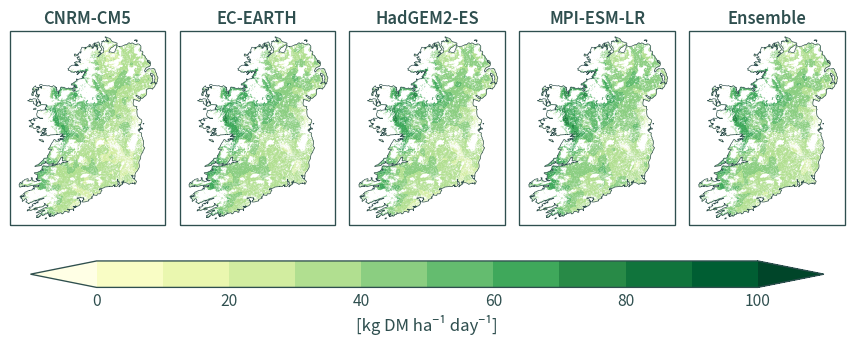

In [9]:
fig = ds["gro"].plot.contourf(
    x="x",
    y="y",
    col="model",
    robust=True,
    extend="both",
    cmap="YlGn",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.lambert_conformal,
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(9, 4.75),
    levels=[0 + 10 * n for n in range(11)],
    cbar_kwargs={
        "label": "[kg DM ha⁻¹ day⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
    },
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

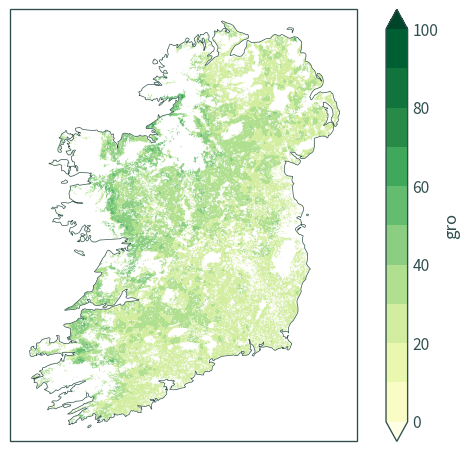

In [10]:
axis = plt.axes(projection=cplt.plot_projection)
mera["gro"].plot.contourf(
    ax=axis,
    robust=True,
    extend="both",
    cmap="YlGn",
    levels=[0 + 10 * n for n in range(11)],
    transform=cplt.lambert_conformal,
)
mask_layer.to_crs(cplt.plot_projection).plot(
    ax=axis, color="white", linewidth=0
)
cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
    ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
)
plt.xlim(-1.775, 1.6),
plt.ylim(-2.1, 2.1),
plt.xlabel(None)
plt.ylabel(None)
plt.title("")
plt.tight_layout()
plt.show()

In [19]:
plot_data = (
    (ds - mera).assign_coords(dataset="EURO-CORDEX").expand_dims(dim="dataset")
)

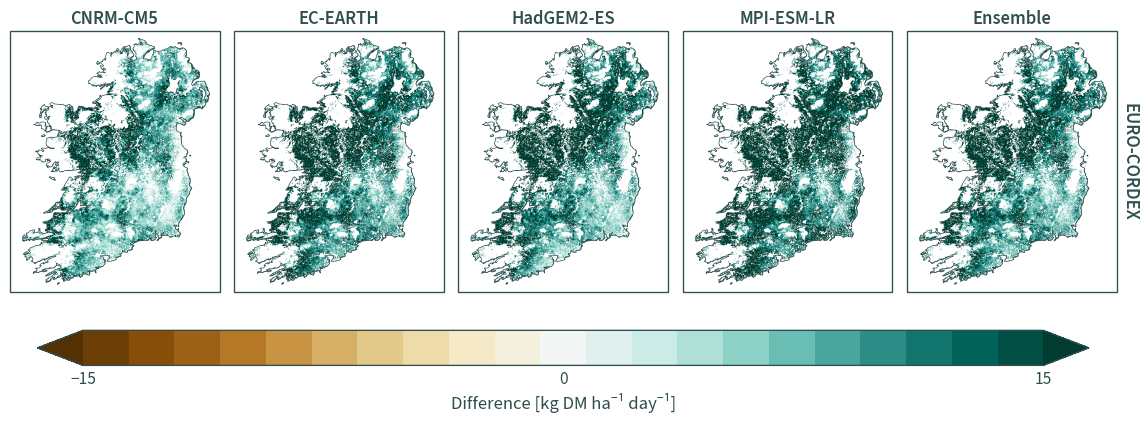

In [22]:
fig = plot_data["gro"].plot.contourf(
    x="x",
    y="y",
    col="model",
    row="dataset",
    robust=True,
    extend="both",
    cmap="BrBG",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.lambert_conformal,
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(12, 5),
    levels=cstats.colorbar_levels(15),
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹ day⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": cstats.colorbar_ticks(15),
    },
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

## HiResIreland

In [13]:
ds_, _ = generate_stats("HiResIreland")

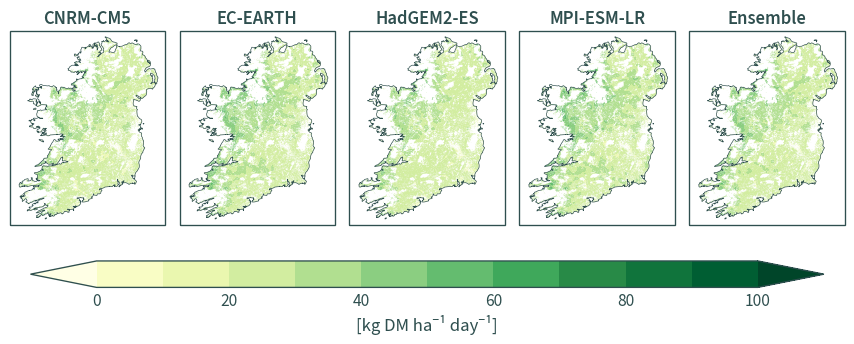

In [14]:
fig = ds_["gro"].plot.contourf(
    x="x",
    y="y",
    col="model",
    robust=True,
    extend="both",
    cmap="YlGn",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.lambert_conformal,
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(9, 4.75),
    levels=[0 + 10 * n for n in range(11)],
    cbar_kwargs={
        "label": "[kg DM ha⁻¹ day⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
    },
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

In [23]:
plot_data = (
    (ds_ - mera)
    .assign_coords(dataset="HiResIreland")
    .expand_dims(dim="dataset")
)

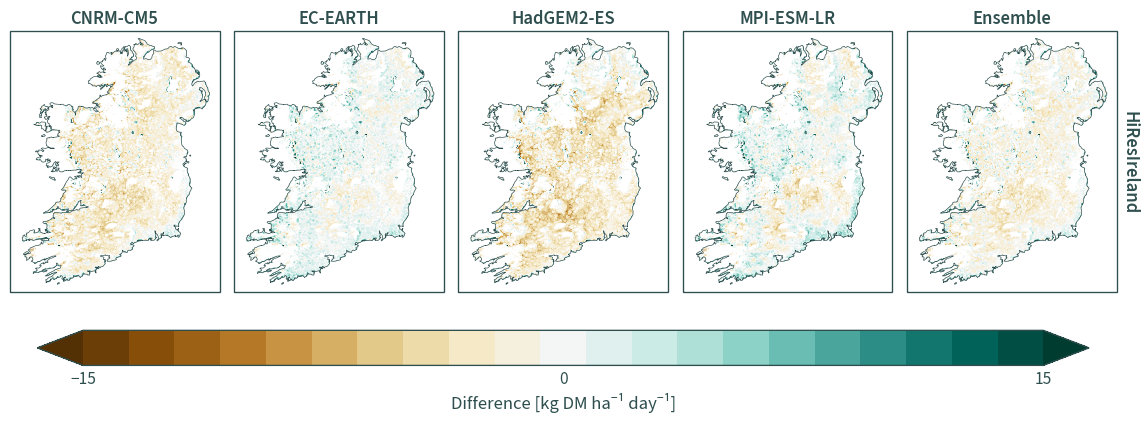

In [25]:
fig = plot_data["gro"].plot.contourf(
    x="x",
    y="y",
    col="model",
    row="dataset",
    robust=True,
    extend="both",
    cmap="BrBG",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.lambert_conformal,
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(12, 5),
    levels=cstats.colorbar_levels(15),
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹ day⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": cstats.colorbar_ticks(15),
    },
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()